In [1]:
import pandas as pd
from helpers.LyricsClassficationExperiment import LyricsClassificationExperiment

english = pd.read_csv(
    "../../data/poptrag_lyrics_genres_corpus_filtered_english_lemmatized.csv"
)

experiment_monroe = LyricsClassificationExperiment(
    corpus=english,
    genrecol="cat12",
    lyricscol="lyrics_lemmatized",
    artistcol="track.s.firstartist.name",
    random_state=42,
    subsample_debug=1.0,
    output_dir="data/experiment_outputs/Monroe_Extractor_Test_fulldata",
)
experiment_monroe.compute_monroe_ngram_features(
    use_stopword_filter=True,
    use_bigram_boundary_filter=True,
    include_unigrams=True,
    prior_concentration=1.0,
    p_value=0.001,
)

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


Artist split validated: 5389 train, 1348 test (disjoint)
Loaded z-scores from checkpoint: 70a836c5...
Selected vocabulary size: 32,573 n-grams (BH FDR=0.001)
MonroeExtractor configured: Monroe N-grams (min 20 artists, with unigrams, stopwords filtered, p=0.001 (FDR correction), prior_concentration=1.0)


In [7]:
from scipy.io import mmwrite
mmwrite("data/experiment_outputs/Monroe_Extractor_Test_fulldata/X_train_from_python.mtx", experiment_monroe.X_train)
mmwrite("data/experiment_outputs/Monroe_Extractor_Test_fulldata/X_test_from_python.mtx", experiment_monroe.X_test)

# R Conversion
Please convert the daa using the R script: tranform_stm_data.R

# Import and Train

In [2]:
import pandas as pd
X_train_new = pd.read_csv("data/experiment_outputs/STM_Test_fulldata/X_train_stm.csv")
X_test_new = pd.read_csv("data/experiment_outputs/STM_Test_fulldata/X_test_stm.csv")

In [3]:
import copy

experiment_stm = copy.deepcopy(experiment_monroe)
experiment_stm.X_train = X_train_new
experiment_stm.X_test = X_test_new
experiment_stm.train_fixed_parametrer_logistic_regression()


Training pipeline with fixed parameters...


In [4]:
experiment_stm.show_model_evaluation()
experiment_stm.show_top_coefficients_per_genre()
experiment_stm.save_model_evaluation_txt()

Model evaluation on test set:
F1 macro: 0.220
Precision macro: 0.247
Recall macro: 0.294
Cohen's kappa: 0.165
------------------------------------------------------------
Classification report:
                  precision    recall  f1-score   support

alternative rock       0.07      0.14      0.09       951
      electronic       0.17      0.15      0.16      1672
       hard rock       0.11      0.12      0.12      1019
     heavy metal       0.14      0.26      0.18      1052
         hip hop       0.50      0.73      0.59      1205
      indie rock       0.06      0.31      0.10       610
            jazz       0.05      0.47      0.09       377
           metal       0.47      0.52      0.50      2023
             pop       0.50      0.25      0.33      5353
        pop rock       0.03      0.15      0.06       361
            rock       0.61      0.12      0.20      8303

        accuracy                           0.24     22926
       macro avg       0.25      0.29      0.22   

In [15]:
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "clf",
            LogisticRegression(
                penalty="elasticnet",
                solver="saga",
                C=1.0,
                l1_ratio=0.5,
                max_iter=1000,
                random_state=42,
                n_jobs=-1,
            ),
        ),
    ]
)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipeline,
    X=experiment_stm.X_train,
    y=experiment_stm.y_train,
    cv=cv,
    train_sizes=np.linspace(0.1, 1.0, 20),
    scoring="f1_macro",
    n_jobs=-1,
)

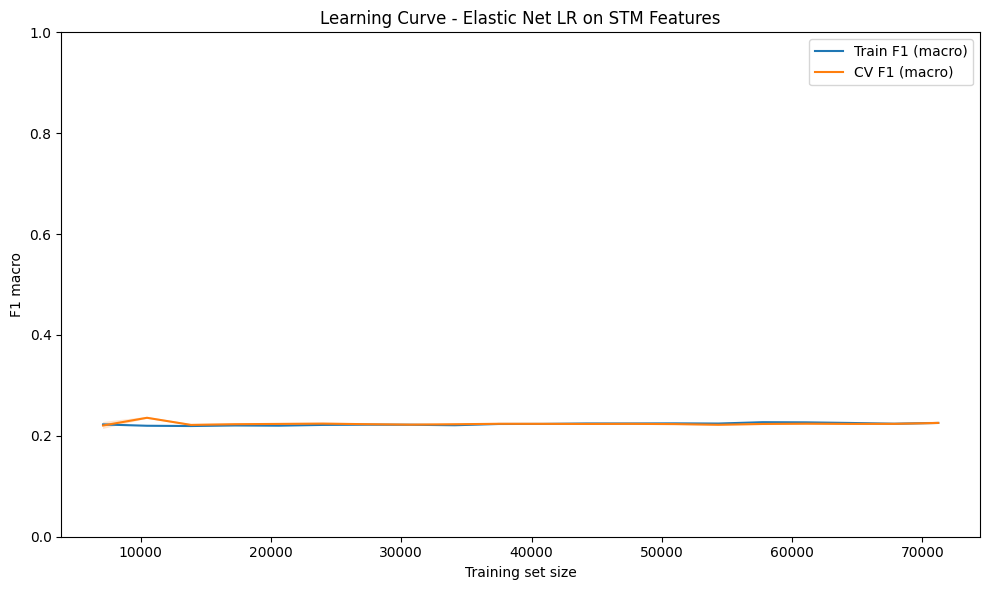

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train_sizes, train_scores.mean(axis=1), label="Train F1 (macro)")
ax.fill_between(
    train_sizes,
    train_scores.mean(axis=1) - train_scores.std(axis=1),
    train_scores.mean(axis=1) + train_scores.std(axis=1),
    alpha=0.2,
)
ax.plot(train_sizes, test_scores.mean(axis=1), label="CV F1 (macro)")
ax.fill_between(
    train_sizes,
    test_scores.mean(axis=1) - test_scores.std(axis=1),
    test_scores.mean(axis=1) + test_scores.std(axis=1),
    alpha=0.2,
)
ax.set_xlabel("Training set size")
ax.set_ylabel("F1 macro")
ax.set_ylim(0, 1)
ax.set_title("Learning Curve - Elastic Net LR on STM Features")
ax.legend()
plt.tight_layout()

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipeline_rf = Pipeline(
    [
        (
            "clf",
            RandomForestClassifier(
                n_estimators=1000,
                max_depth=None,
                min_samples_leaf=50,
                n_jobs=-1,
                random_state=42,
            ),
        ),
    ]
)

pipeline_rf.fit(experiment_stm.X_train, experiment_stm.y_train)

y_pred = pipeline_rf.predict(experiment_stm.X_test)

print(classification_report(experiment_stm.y_test, y_pred))

                  precision    recall  f1-score   support

alternative rock       0.00      0.00      0.00       951
      electronic       0.33      0.04      0.07      1672
       hard rock       0.00      0.00      0.00      1019
     heavy metal       0.29      0.02      0.04      1052
         hip hop       0.64      0.67      0.66      1205
      indie rock       0.00      0.00      0.00       610
            jazz       0.00      0.00      0.00       377
           metal       0.49      0.57      0.52      2023
             pop       0.47      0.50      0.48      5353
        pop rock       0.00      0.00      0.00       361
            rock       0.48      0.76      0.59      8303

        accuracy                           0.48     22926
       macro avg       0.24      0.23      0.21     22926
    weighted avg       0.40      0.48      0.41     22926



N:\Materialien\Promotion\LyricsGenreRecognition\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
N:\Materialien\Promotion\LyricsGenreRecognition\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
N:\Materialien\Promotion\LyricsGenreRecognition\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag